## Изучения паттернов цвета и формы

In [1]:
!pip install datasets jaxtyping better_abc pillow wandb circuitsvis


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


#### Связи проекта

In [2]:
import sys
from pathlib import Path

In [3]:
path = "."
# for kaggle
# path = "/kaggle/input/logitlens30/LogitLens/research/logit-lens/notebook"

ROOT = Path(path).absolute().parent.parent.parent

DATA = ROOT / "data"

In [4]:
if ROOT not in sys.path:
    sys.path.append(str(ROOT))

#### Импорт библиотек

In [5]:
import torch
from PIL import Image
import circuitsvis as cv
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from math import ceil
import json

import transformer_lens.utils as utils
from transformer_lens import HookedTransformer

from research.utils import get_data_images, get_data_image_cache
from research.utils import plot_data, plot_data_attention, plot_images, plot_attention_mask, plot_composite_attention, plot_text_attention, plot_attention_mask_cache, get_data_image_cache

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1738601356.098610     557 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


#### Цвет

Создаем модель

In [8]:
torch.set_grad_enabled(False)

In [9]:
device = utils.get_device()

In [10]:
model_name = "llava-hf/llava-1.5-7b-hf"
last_layer = 32

In [11]:
model = HookedTransformer.from_pretrained(model_name, device=device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Loaded pretrained model llava-hf/llava-1.5-7b-hf into HookedTransformer


Загружаем изображения из датасета CUB_200_2011

In [12]:
CUB = DATA / "CUB_200_2011"
IMAGE_NAME_FILE = CUB / "images_names.json"

In [13]:
with open(IMAGE_NAME_FILE, mode="r") as file:
    dict_images = json.load(file)

images = [Image.open(CUB / name) for name in dict_images["names"]]
class_images = dict_images["labels"]
token_class_images = [model.to_single_token(cl) for cl in class_images]
prompt = "USER: <image>\nWhat color is the bird? ASSISTANT: The bird is"

Отобразим изображения

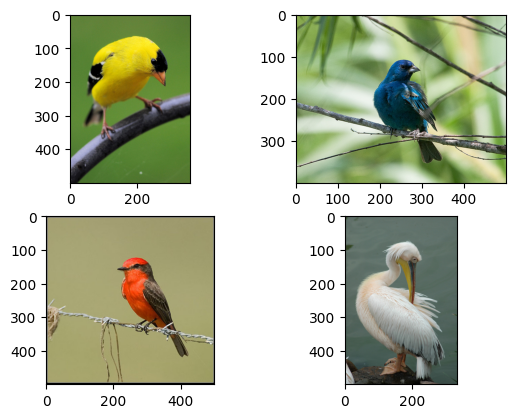

In [14]:
plot_images(images)

Соберем данные для каждого из изображений: токены, вероятность, энтропия, косинусное расстояние между последним слоем и промежуточными слоями модели и внимание.

In [15]:
data, data_attention = get_data_images(model, class_images, prompt, images, last_layer, probs_class=True)

/kaggle/input/logitlens30/LogitLens/research/utils/get_data.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(model_logits)
/kaggle/input/logitlens30/LogitLens/research/utils/get_data.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  :].T).item() / torch.linalg.norm(


Проследим за вероятностями для разных цветов.

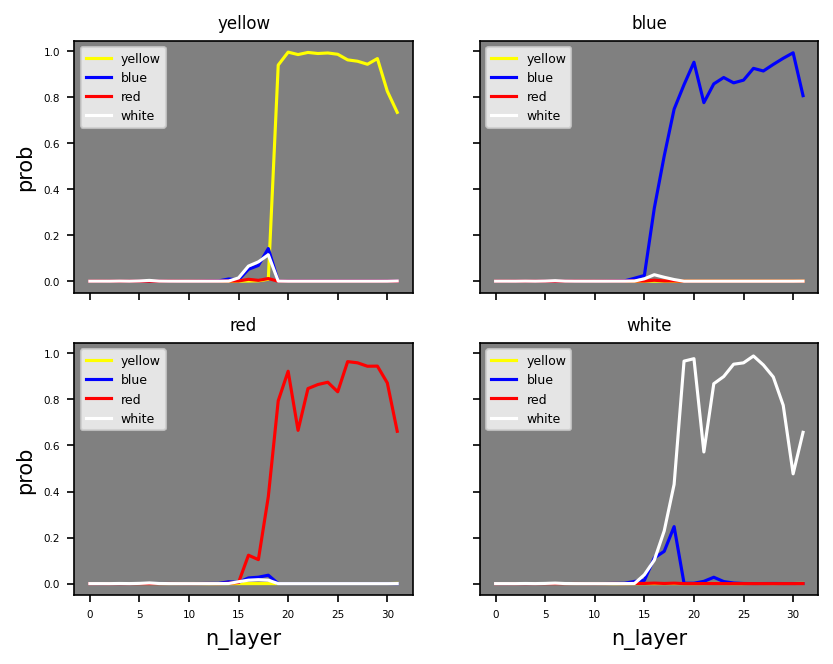

In [16]:
plot_data(data, class_images, data_id=1, show_tokens=False, xlabel="n_layer", ylabel="prob", back_color=(0.502, 0.502, 0.502), class_images_line=True, color_line=True)

График зависимости энтропии от номера слоя.

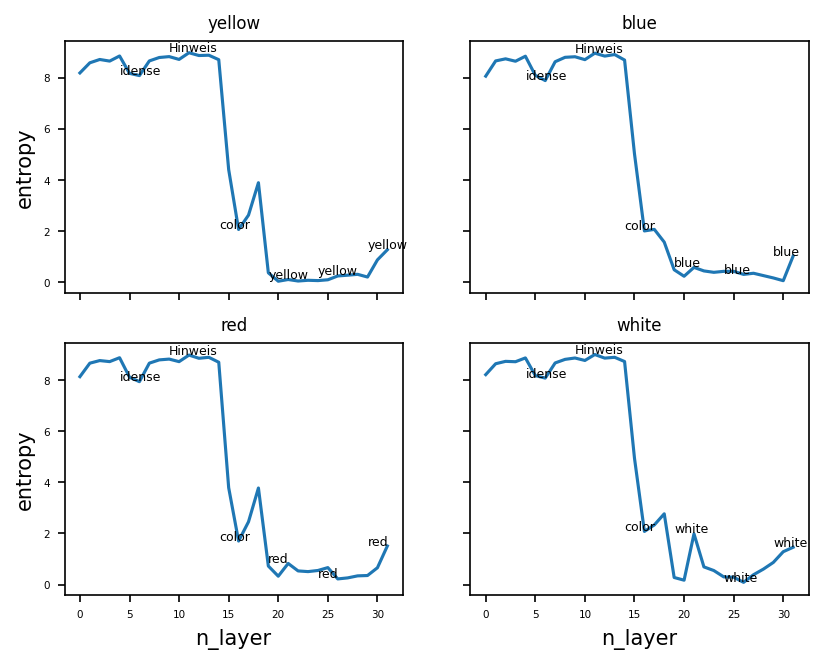

In [17]:
plot_data(data, class_images, data_id=2, xlabel="n_layer", ylabel="entropy")

График зависимости косинусное расстояние между последним слоем и промежуточными слоями модели от номера слоя.

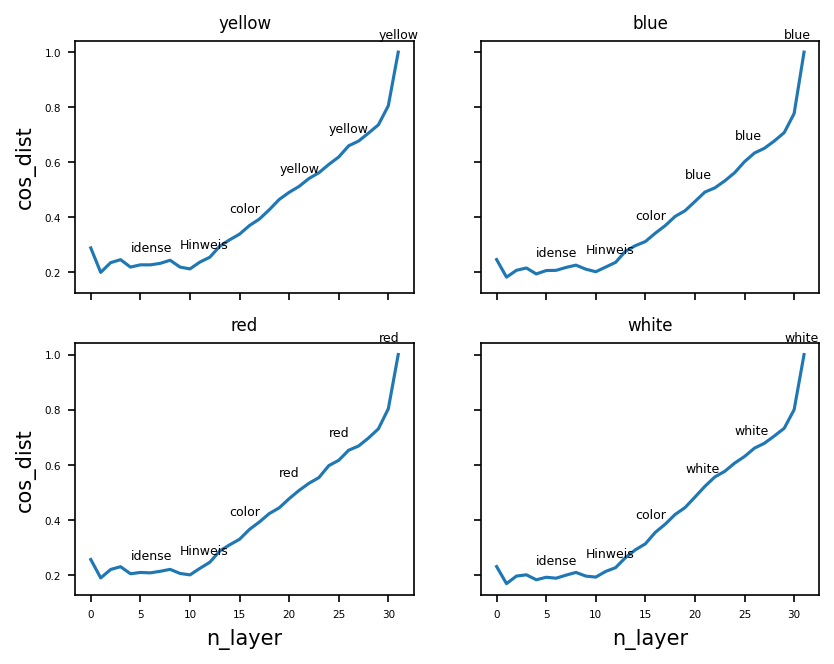

In [18]:
plot_data(data, class_images, data_id=3, xlabel="n_layer", ylabel="cos_dist")

Графики зависимости усредненного внимания от номера слоя.

Внимание в изображении

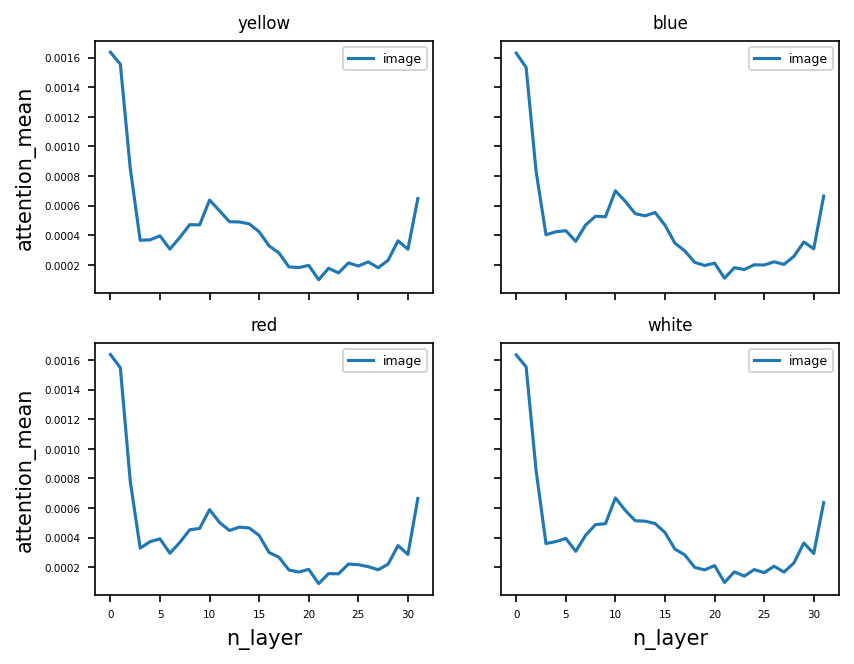

In [19]:
plot_data_attention(data_attention, class_images, label="image", xlabel='n_layer', ylabel='attention_mean')

Внимание от последнего логита на изображении на разных слоях. Последнее изображение - усредненное по всем слоям внимание.

/usr/local/lib/python3.10/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


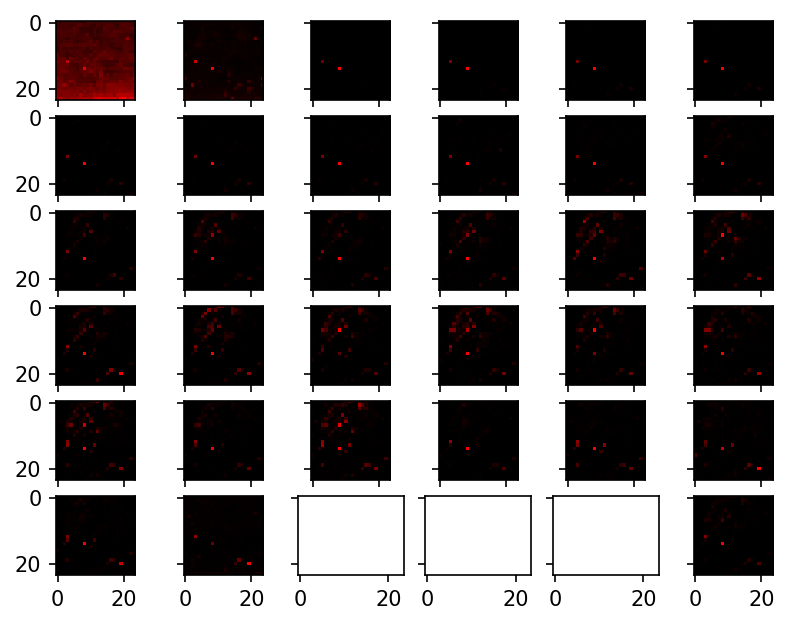

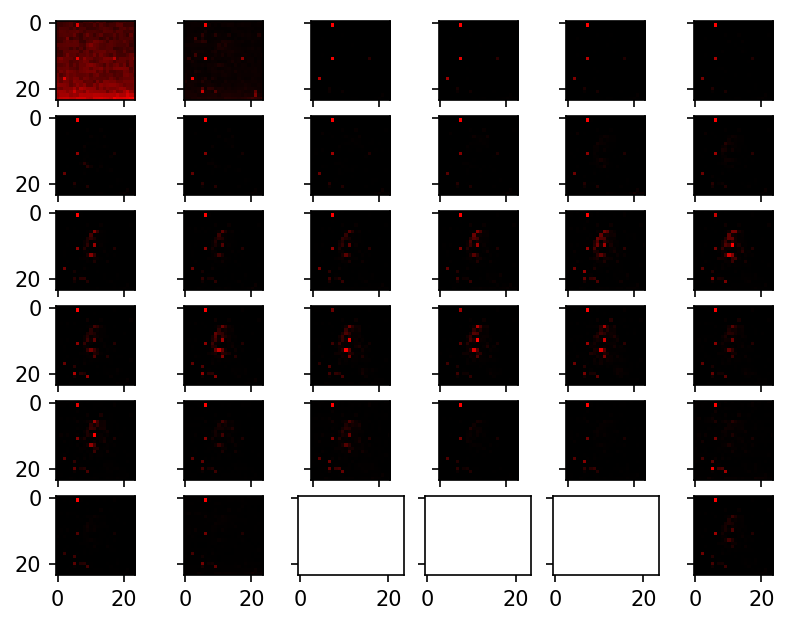

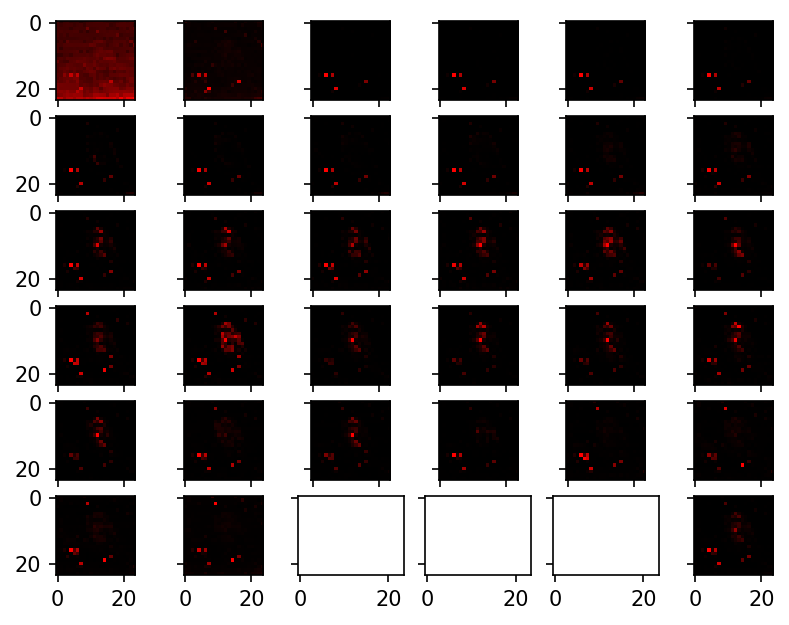

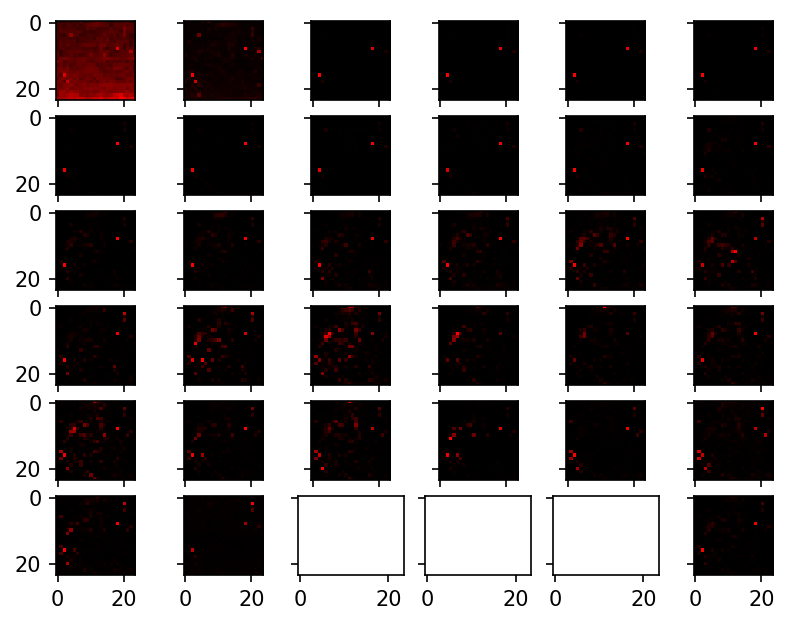

In [20]:
composite_attention, super_pixels0 = plot_attention_mask(model, prompt, images, start_layer=0, 
                                                        composite_layer=15, last_layer=32,
                                                        attention_token="last")

Наложим маску внимания в composite_layer слоя на изображения.

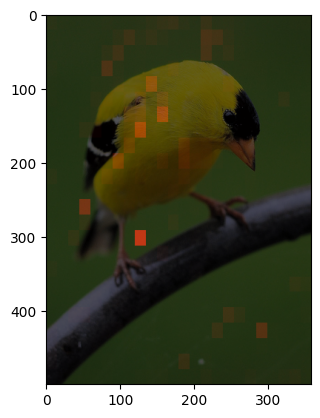

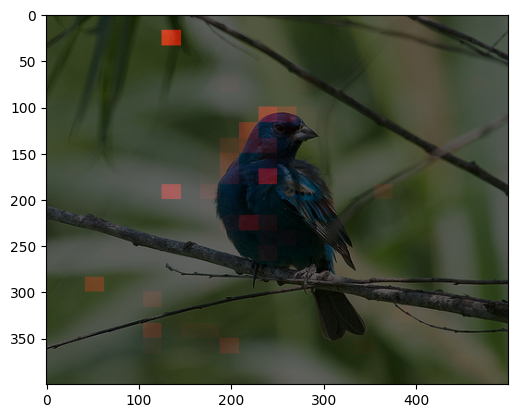

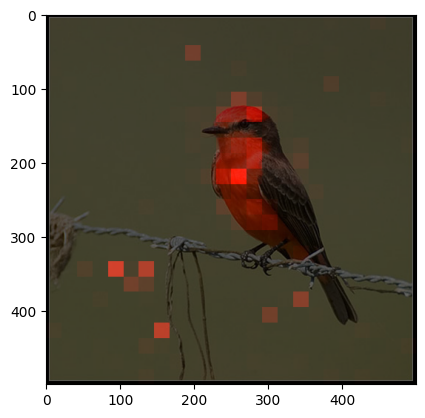

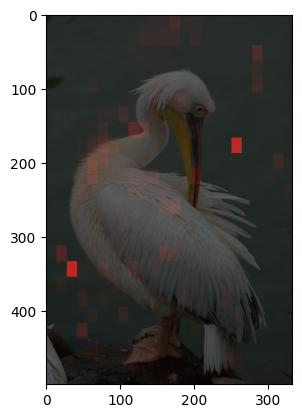

In [21]:
plot_composite_attention(composite_attention, images)

Внимание от логита токена "color" на изображении на разных слоях.

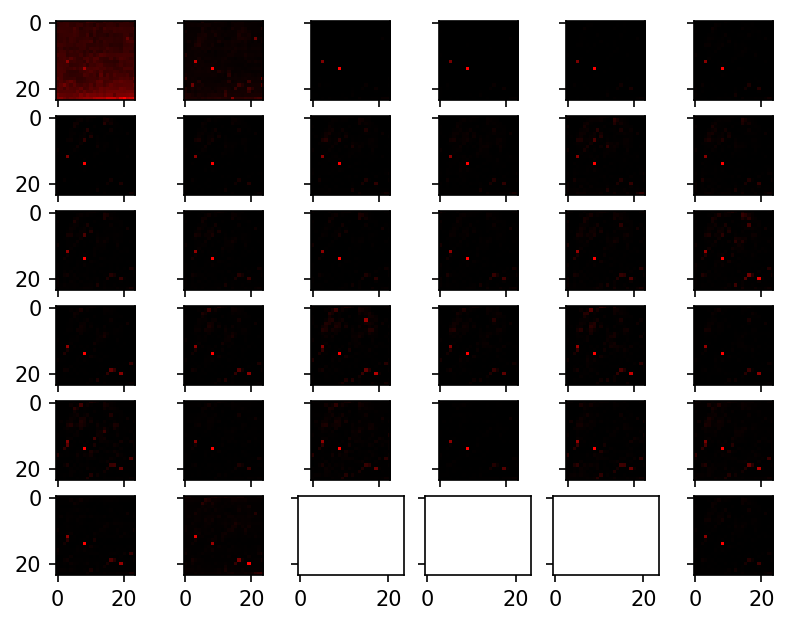

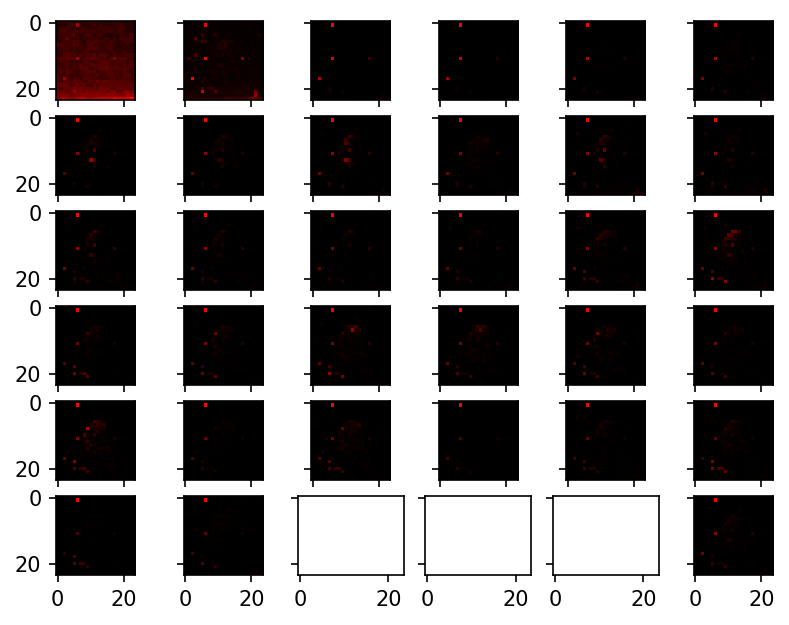

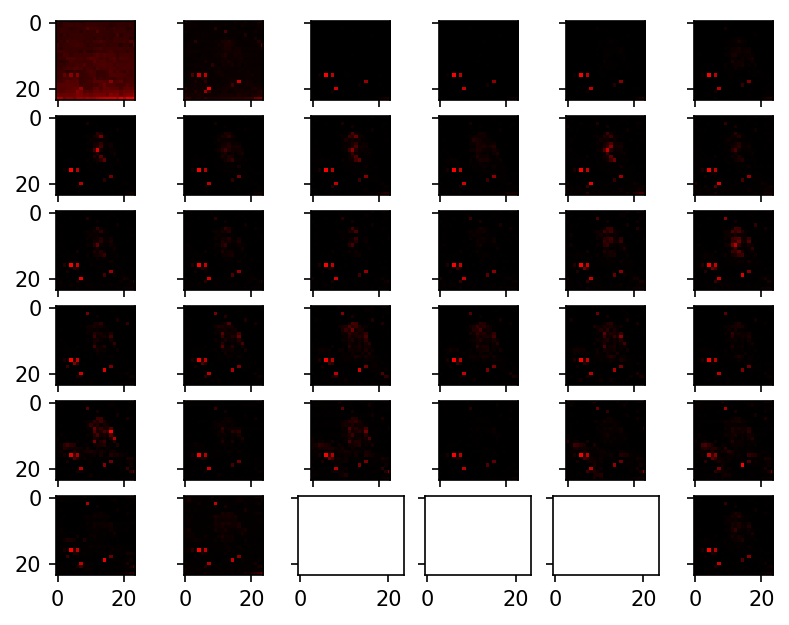

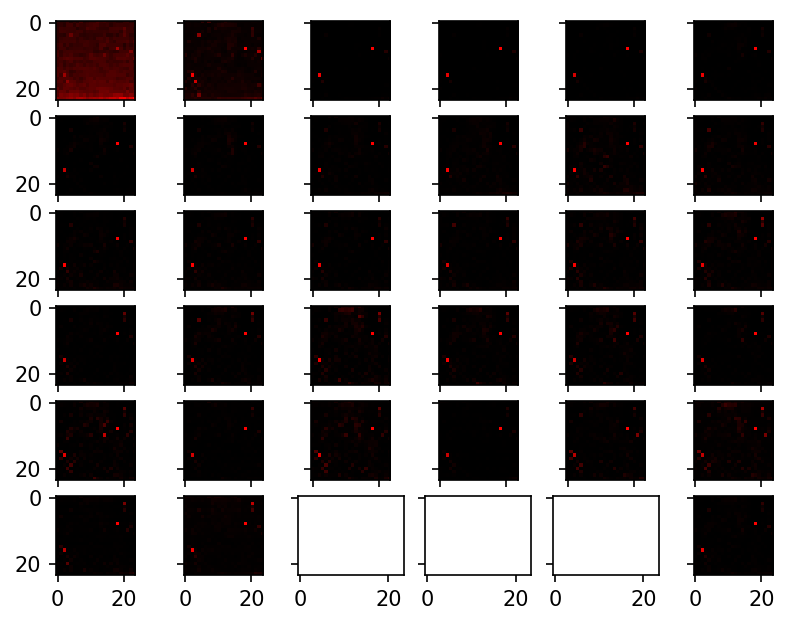

In [22]:
composite_attention, super_pixels1 = plot_attention_mask(model, prompt, images, start_layer=0, 
                                                        composite_layer=15, last_layer=32,
                                                        attention_token="color")

Посмотрим на внимание между токенами в тексте.

In [23]:
plot_text_attention(model, prompt, images[1], layer=18)

In [24]:
plot_text_attention(model, prompt, images[3], layer=23)

#### Форма

Загружаем изображения из датасета 2D geometric shapes dataset

In [25]:
CUB = DATA / "2D_geometric_shapes_dataset"
IMAGE_NAME_FILE = CUB / "images_names.json"

In [26]:
with open(IMAGE_NAME_FILE, mode="r") as file:
    dict_images = json.load(file)

images = [Image.open(CUB / name) for name in dict_images["names"]]
class_images = dict_images["labels"]
token_class_images = [model.to_single_token(cl) for cl in class_images]
prompt = "USER: <image>\nWhat is the shape of the object in the image? ASSISTANT: The shape of the object is a"

Отобразим изображения

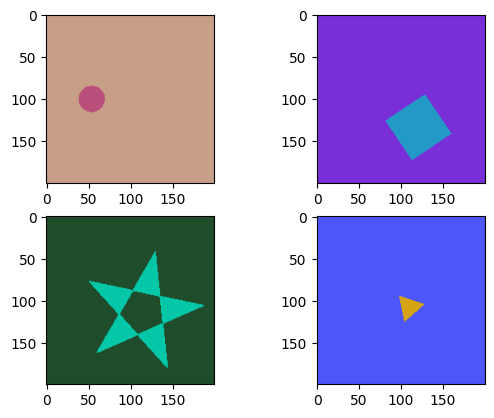

In [27]:
plot_images(images)

Соберем данные для каждого из изображений: токены, вероятность, энтропия, косинусное расстояние между последним слоем и промежуточными слоями модели и внимание.

In [28]:
data, data_attention = get_data_images(model, class_images, prompt, images, last_layer, probs_class=True)

График зависимости вероятности предсказания правильного токена от номера слоя.

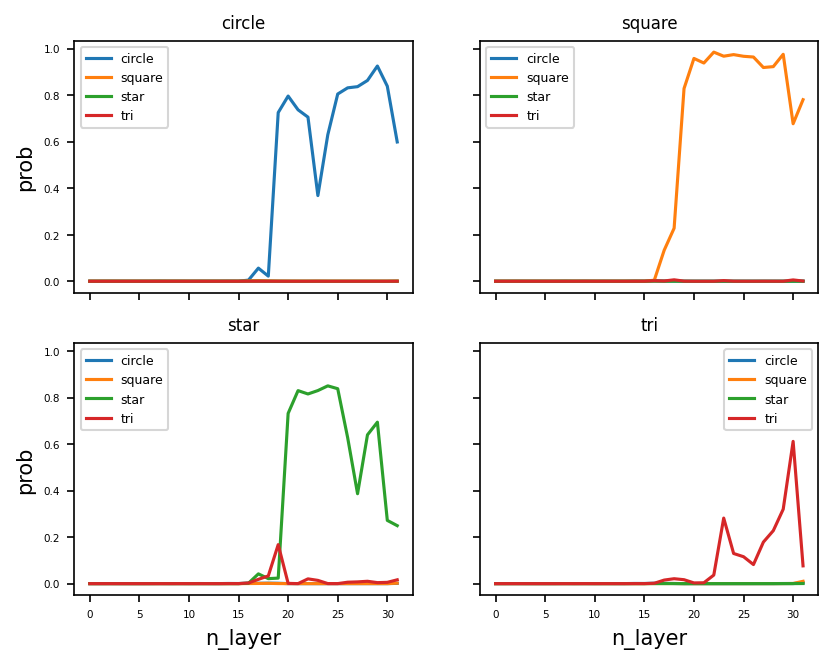

In [29]:
plot_data(data, class_images, data_id=1, show_tokens=False, xlabel="n_layer", ylabel="prob", class_images_line=True)

Графики зависимости усредненного внимания от номера слоя.

Внимание в тексте

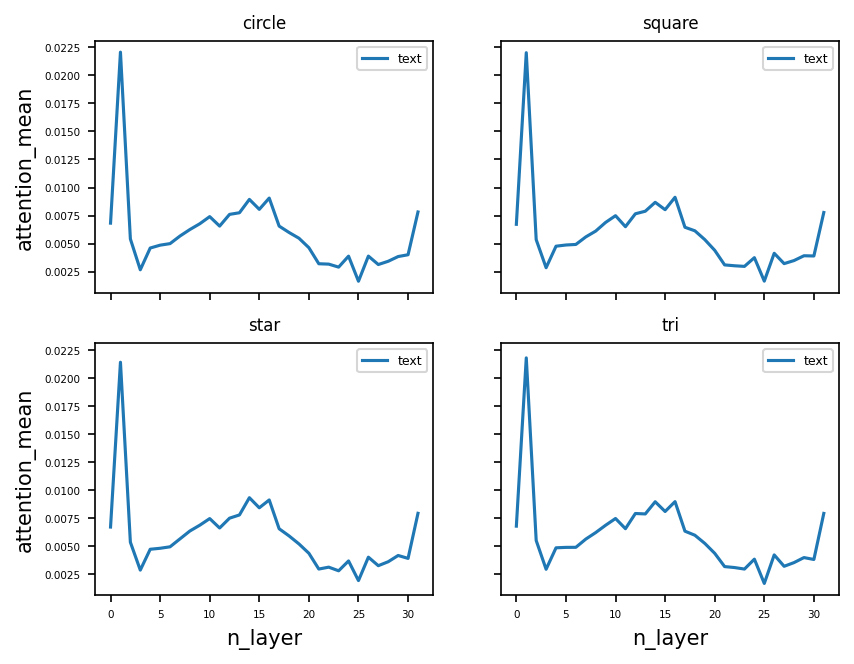

In [30]:
plot_data_attention(data_attention, class_images, label="text", xlabel='n_layer', ylabel='attention_mean')

Внимание от последнего логита на изображении на разных слоях.

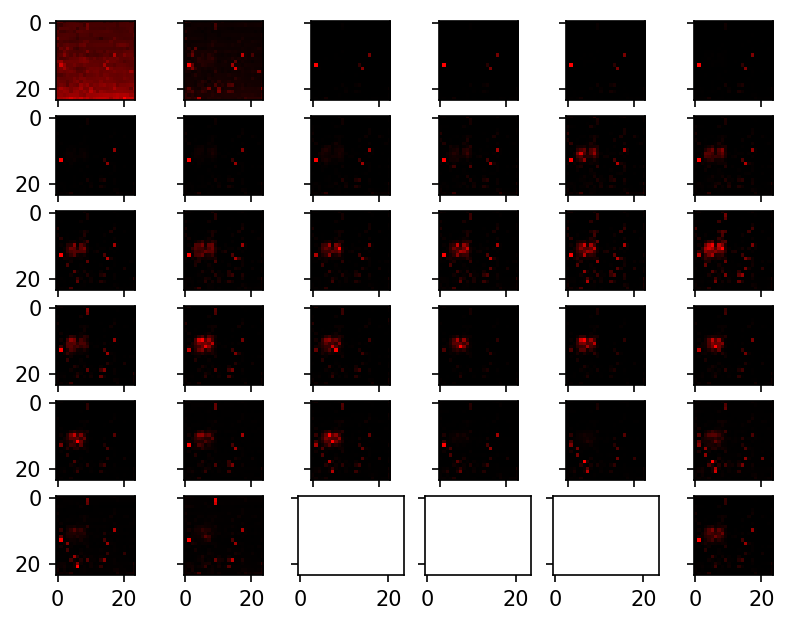

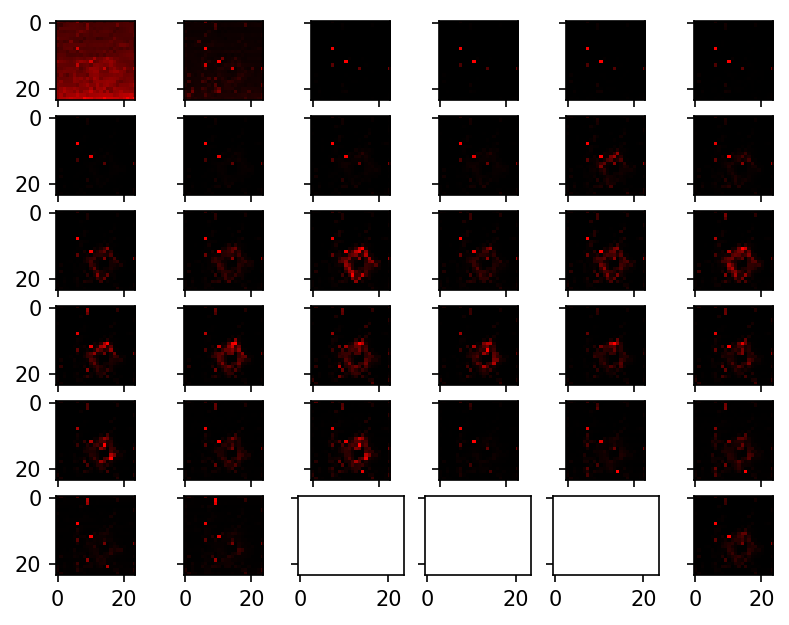

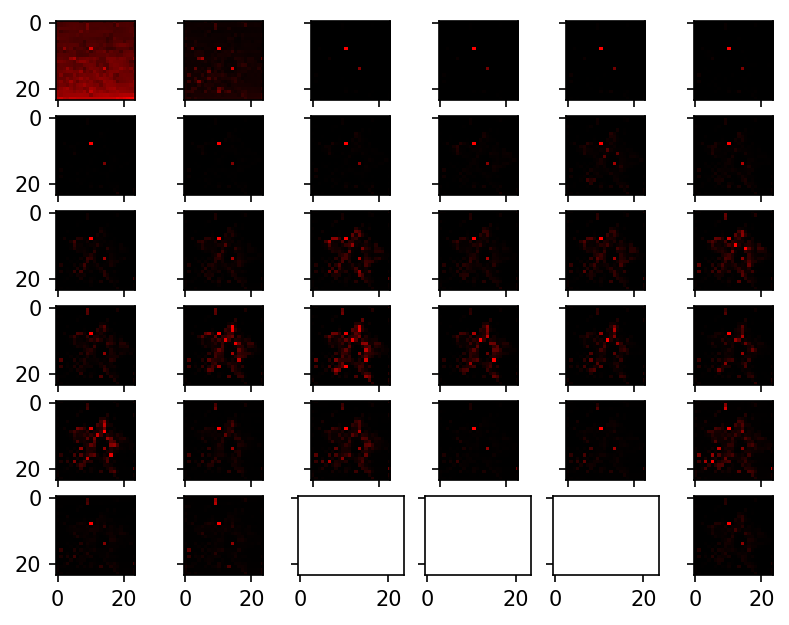

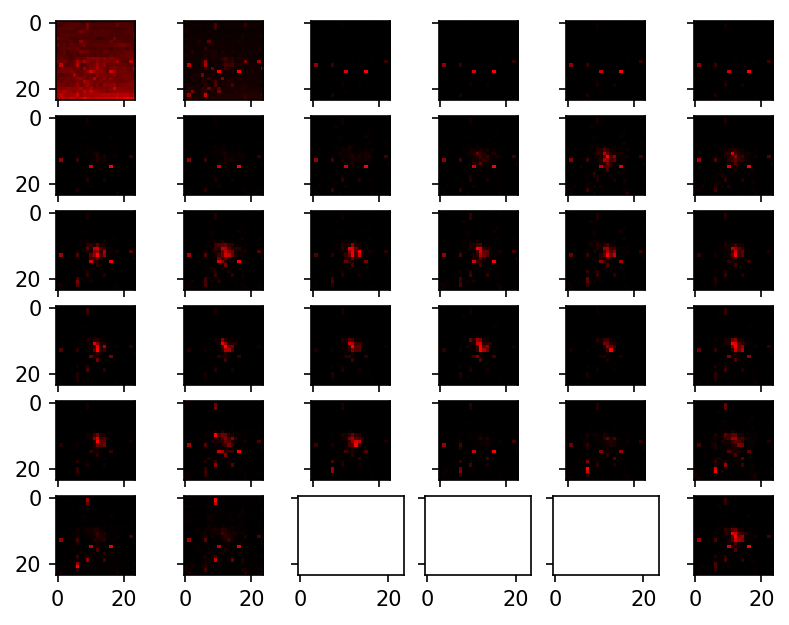

In [31]:
composite_attention, super_pixels2 = plot_attention_mask(model, prompt, images, start_layer=0, 
                                                        composite_layer=15, last_layer=32,
                                                        attention_token="last")

Наложим маску внимания в composite_layer слоя на изображения.

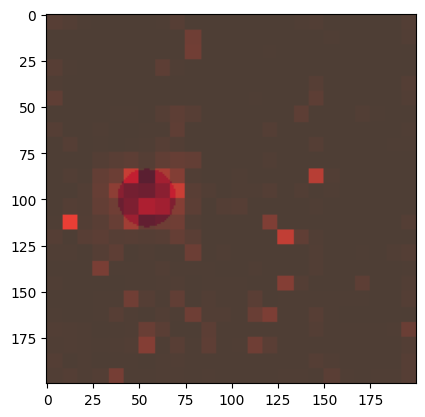

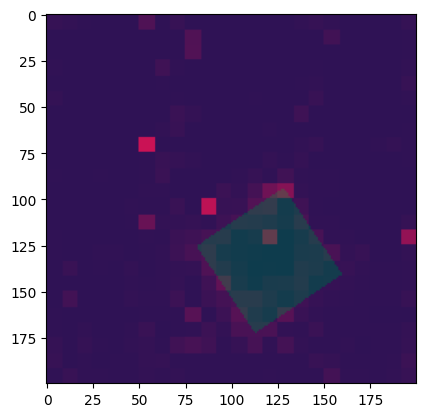

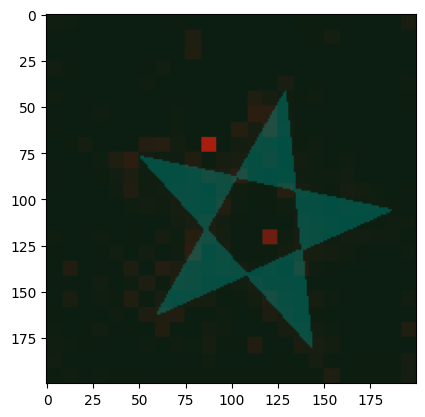

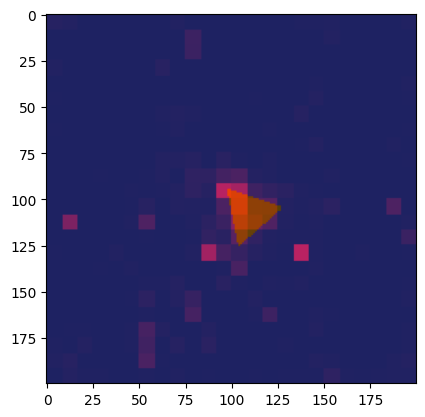

In [32]:
plot_composite_attention(composite_attention, images)

Внимание от логита токена "shape" на изображении на разных слоях.

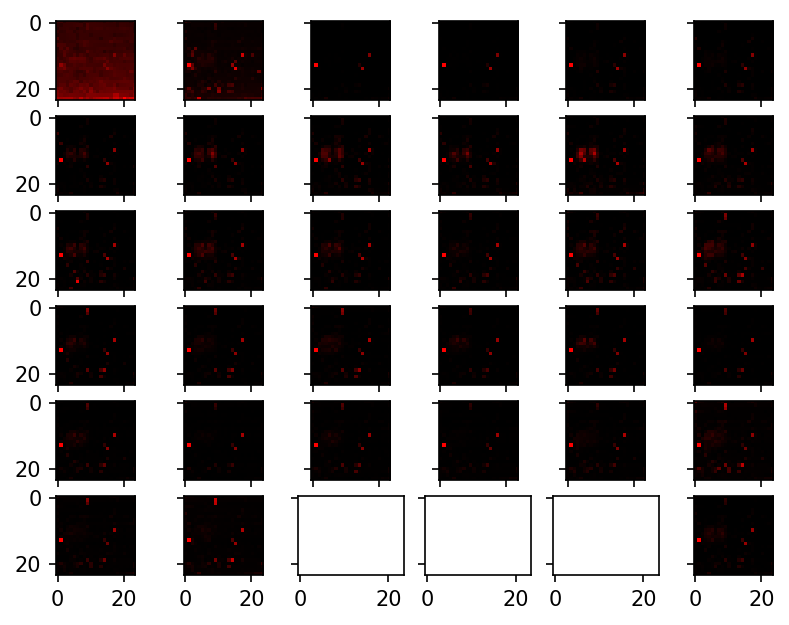

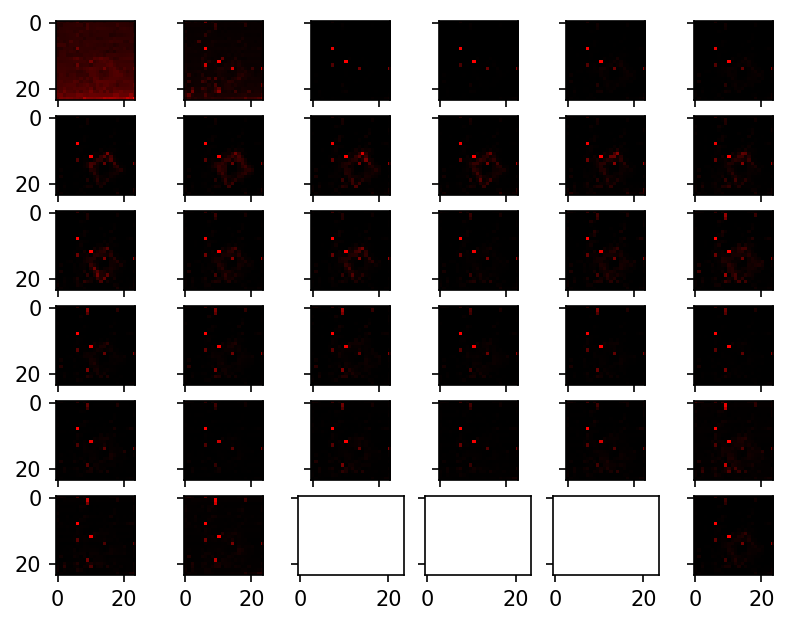

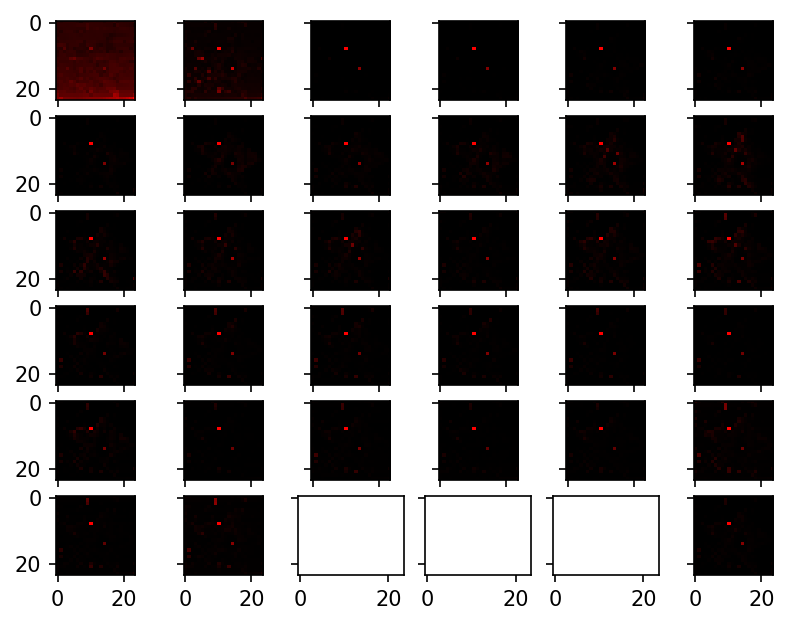

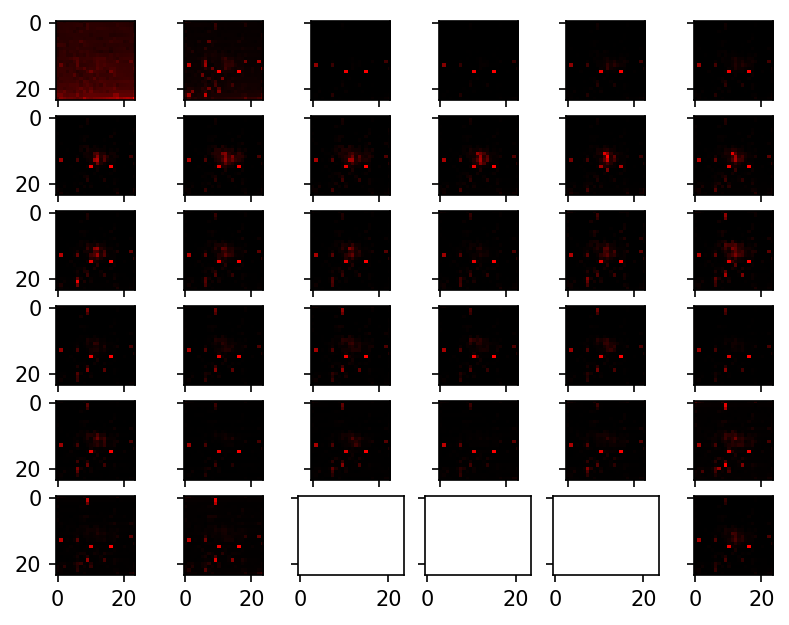

In [33]:
composite_attention, super_pixels3 = plot_attention_mask(model, prompt, images, start_layer=0, 
                                                        composite_layer=15, last_layer=32,
                                                        attention_token="shape")

Посмотрим на внимание между токенами в тексте.

In [34]:
plot_text_attention(model, prompt, images[0], layer=15)

In [35]:
plot_text_attention(model, prompt, images[2], layer=20)

На изображении можно заметить несколько логитов, которые актвируются очень часто для выбранного логита, от которого задается query. Они остаются часто используемыми на протяжении всей модели.

Попробуем их обнулить.

Для птиц наиболее встречаемые пиксели внимания (в кортеже находится относительный индекс и частота того, как часто пиксель становился наибольшим на матрице внимания).

In [36]:
super_pixels0, super_pixels1

([[(344, 26), (176, 3), (499, 2), (572, 1)],
  [(30, 26), (251, 3), (575, 1), (270, 1), (322, 1)],
  [(388, 19), (252, 8), (575, 1), (487, 1), (157, 1), (470, 1), (57, 1)],
  [(210, 11),
   (386, 11),
   (197, 2),
   (68, 2),
   (571, 1),
   (300, 1),
   (389, 1),
   (11, 1),
   (483, 1),
   (267, 1)]],
 [[(344, 30), (572, 1), (499, 1)],
  [(30, 30), (575, 1), (410, 1)],
  [(388, 28), (575, 1), (487, 1), (232, 1), (470, 1)],
  [(210, 29), (386, 2), (575, 1)]])

Для фигур:

In [37]:
super_pixels2, super_pixels3

([[(313, 19),
   (245, 3),
   (294, 3),
   (272, 2),
   (437, 2),
   (572, 1),
   (319, 1),
   (510, 1)],
  [(298, 10),
   (198, 9),
   (279, 3),
   (278, 3),
   (326, 3),
   (519, 2),
   (575, 1),
   (33, 1)],
  [(202, 26), (575, 1), (279, 1), (442, 1), (400, 1), (252, 1), (230, 1)],
  [(376, 13),
   (300, 5),
   (324, 4),
   (325, 2),
   (510, 2),
   (575, 1),
   (302, 1),
   (275, 1),
   (249, 1),
   (486, 1),
   (33, 1)]],
 [[(313, 31), (572, 1)],
  [(198, 19), (298, 12), (575, 1)],
  [(202, 31), (575, 1)],
  [(376, 29), (575, 1), (300, 1), (465, 1)]])

In [38]:
def replace_logit_on_zeros(model, prompt, img, get_layer, set_layer, idx_logits):
    _, model_cache = model.run_with_cache(prompt, 
                                          input_images=img, 
                                          remove_batch_dim=False)

    post_block = model_cache[f"blocks.{get_layer}.hook_resid_post"]
    post_block[0, idx_logits, :] = torch.ones(4096)
    start_layer = set_layer
    model_logits, model_cache = model.run_with_cache(post_block, 
                                                    remove_batch_dim=False,
                                                    start_at_layer=start_layer)

    return model_logits, model_cache

In [39]:
max_pixel_ids = super_pixels2[0][0][0]

get_layer = 5
set_layer = 6
model_logits, model_cache = replace_logit_on_zeros(model, prompt, images[0], get_layer, set_layer, max_pixel_ids)

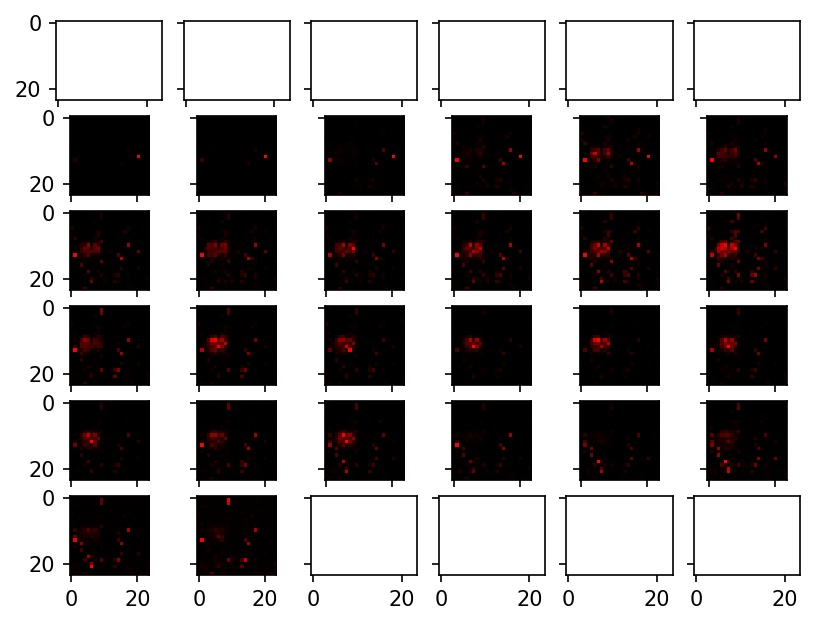

In [40]:
composite_attention = []

model_str_tokens = model.to_str_tokens(prompt)
idx_image = model_str_tokens.index("<image>")
n = len(model_str_tokens)
n_a = model_cache["pattern", set_layer, "attn"].shape[-1]
n_i = int((n_a - n + 1) ** 0.5)
super_pixels, mask_mean = plot_attention_mask_cache(model_cache, composite_attention, n_i, -1,
                                                   idx_image, last_layer=last_layer, start_layer=set_layer,
                                                   composite_layer=15)

In [41]:
data_image, data_attention_image = get_data_image_cache(model, model_cache, prompt, 
                                                        token_class_images, 
                                                        last_layer=last_layer, 
                                                        start_layer=set_layer,
                                                        probs_class=False)

In [42]:
data, data_attention = [data_image], [data_attention_image]

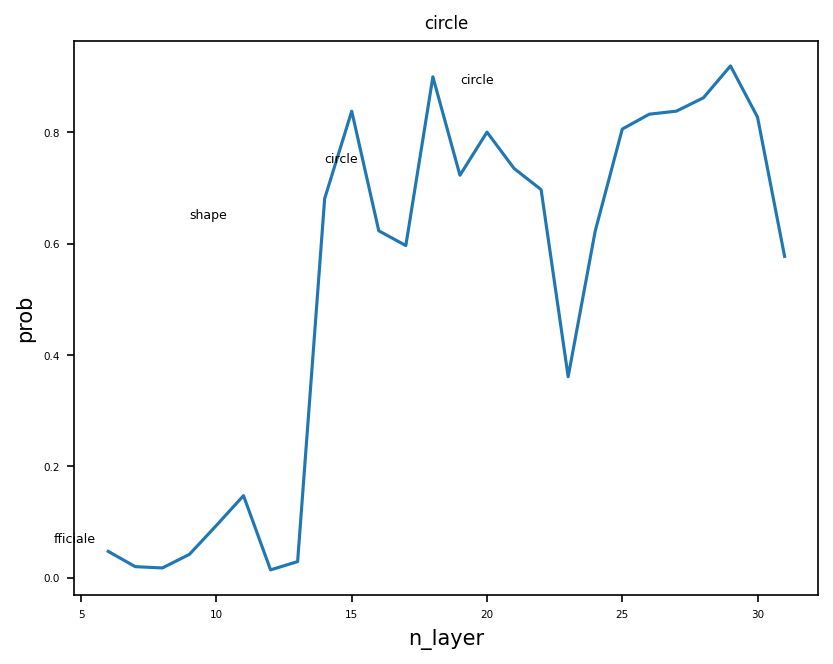

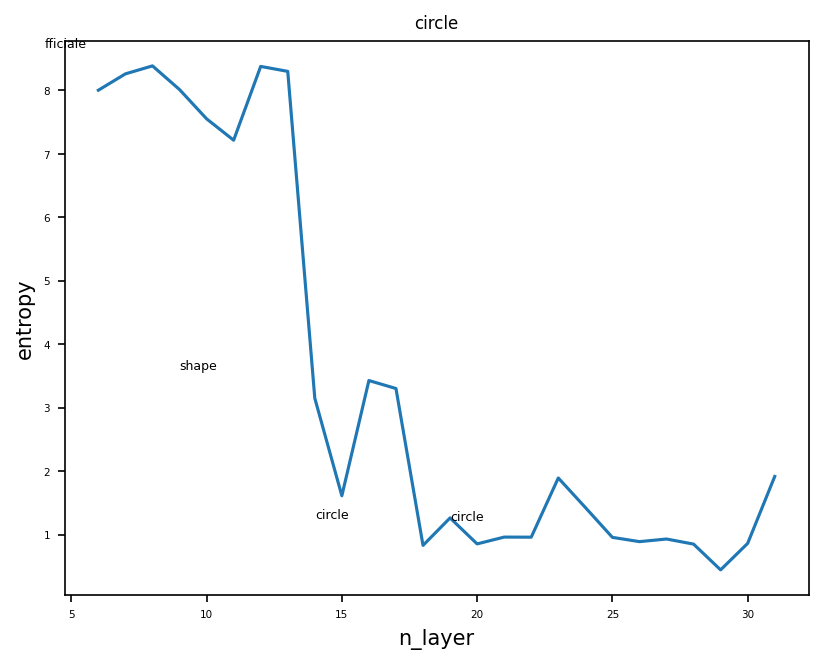

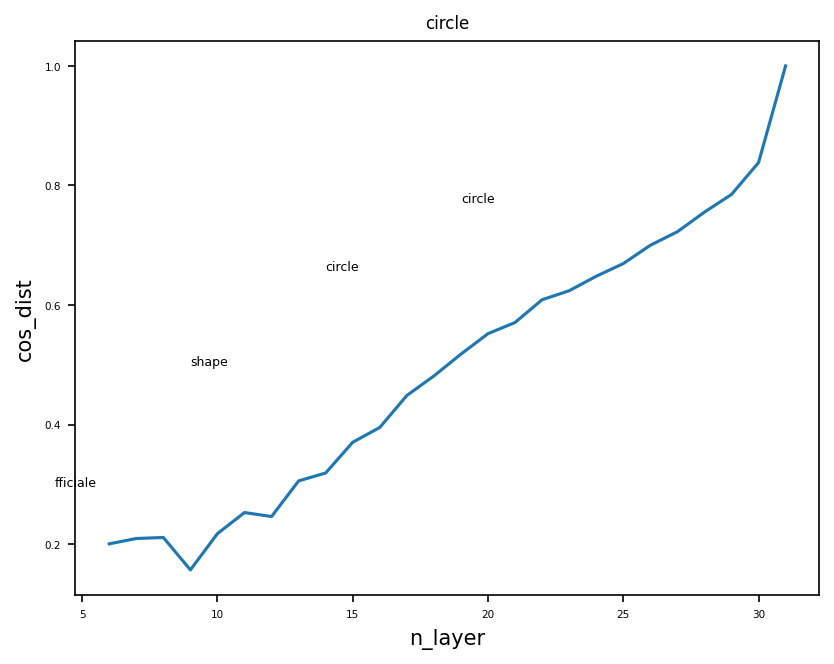

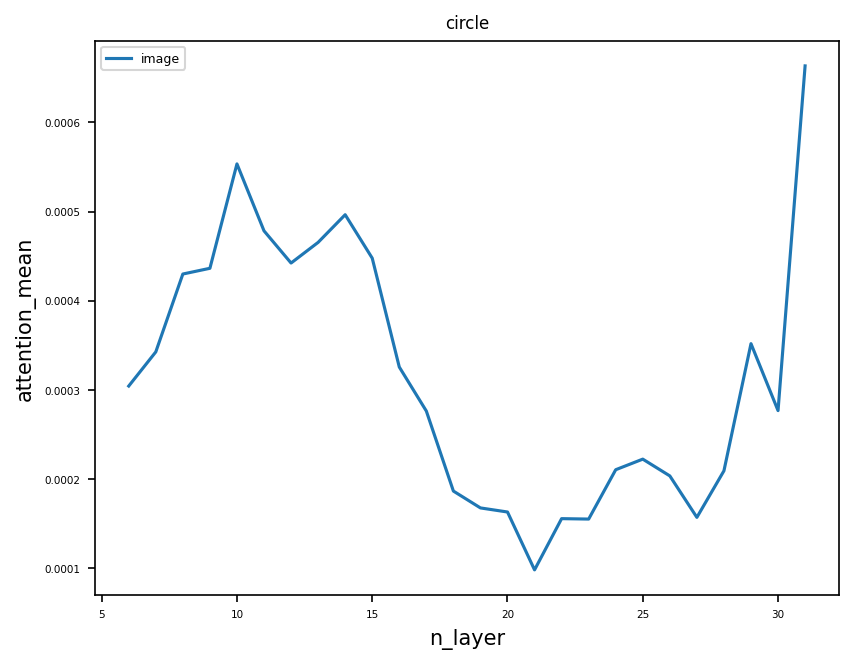

In [43]:
plot_data(data, ["circle"], data_id=1, xlabel='n_layer', ylabel='prob', start_layer=set_layer)
plot_data(data, ["circle"], data_id=2, dy=0.3, xlabel='n_layer', ylabel='entropy', start_layer=set_layer)
plot_data(data, ["circle"], data_id=3, xlabel='n_layer', ylabel='cos_dist', start_layer=set_layer)
plot_data_attention(data_attention, ["circle"], label="image", xlabel='n_layer', ylabel='attention_mean', start_layer=set_layer)

In [44]:
super_pixels

[308,
 308,
 308,
 308,
 313,
 313,
 313,
 313,
 272,
 313,
 313,
 272,
 313,
 245,
 319,
 294,
 245,
 294,
 294,
 313,
 294,
 313,
 437,
 437,
 510,
 313]

In [45]:
max_pixel_ids = super_pixels2[0][0][0]

get_layer = 1
set_layer = 2
model_logits, model_cache = replace_logit_on_zeros(model, prompt, images[0], get_layer, set_layer, max_pixel_ids)

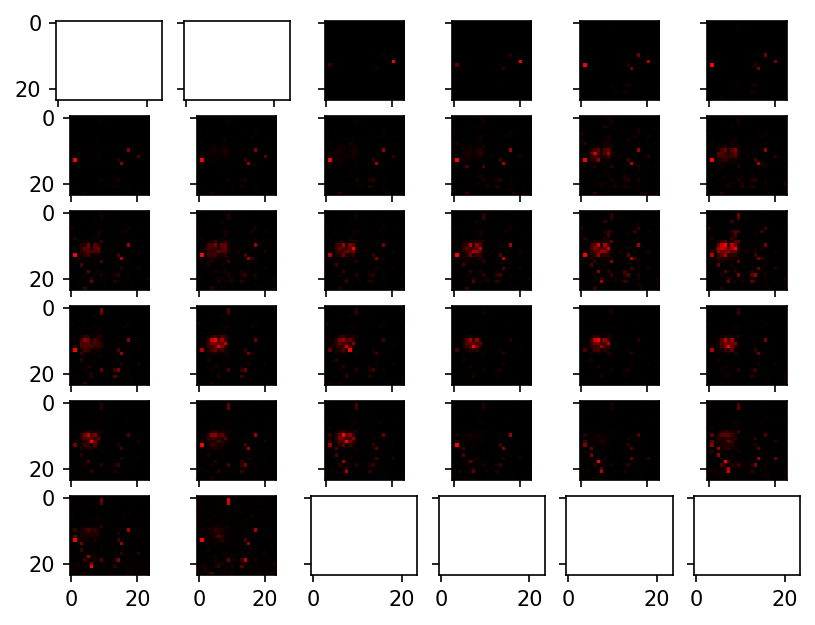

In [46]:
composite_attention = []

model_str_tokens = model.to_str_tokens(prompt)
idx_image = model_str_tokens.index("<image>")
n = len(model_str_tokens)
n_a = model_cache["pattern", set_layer, "attn"].shape[-1]
n_i = int((n_a - n + 1) ** 0.5)
super_pixels, mask_mean = plot_attention_mask_cache(model_cache, composite_attention, n_i, -1,
                                                   idx_image, last_layer=last_layer, start_layer=set_layer,
                                                   composite_layer=15)

In [47]:
data, data_attention = [data_image], [data_attention_image]

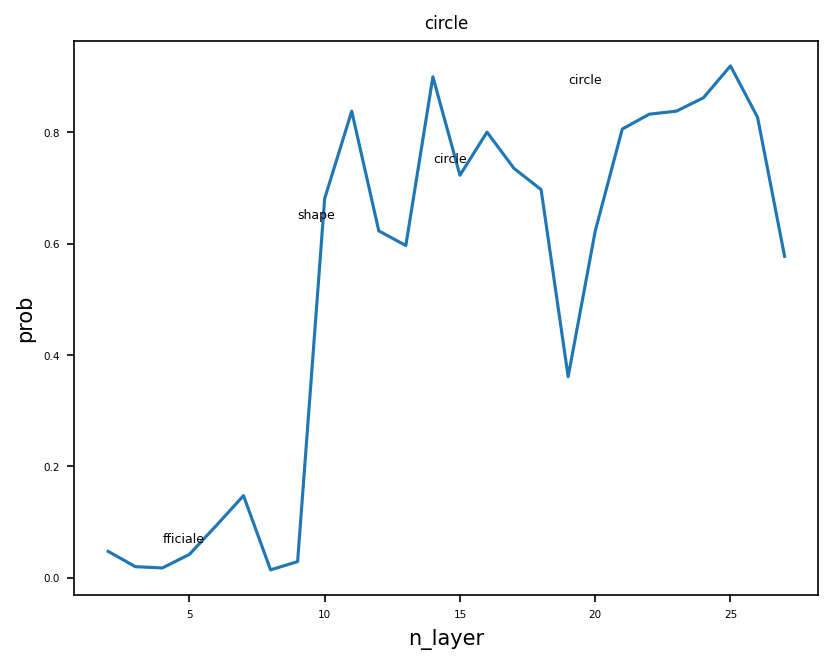

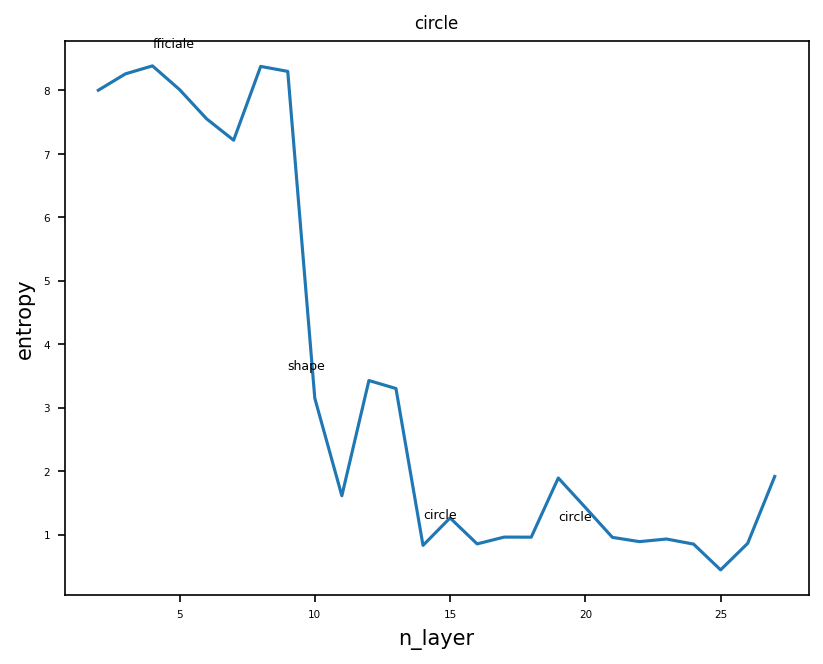

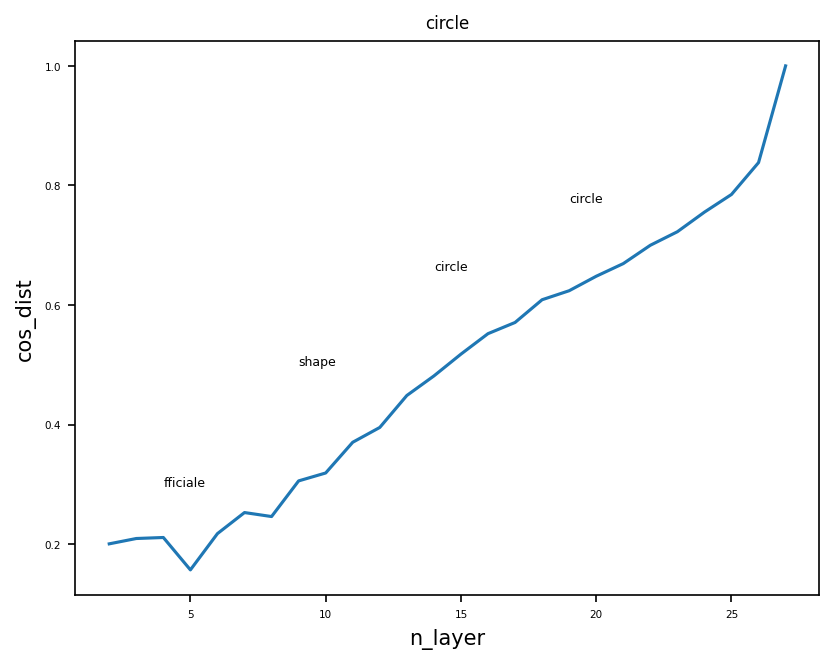

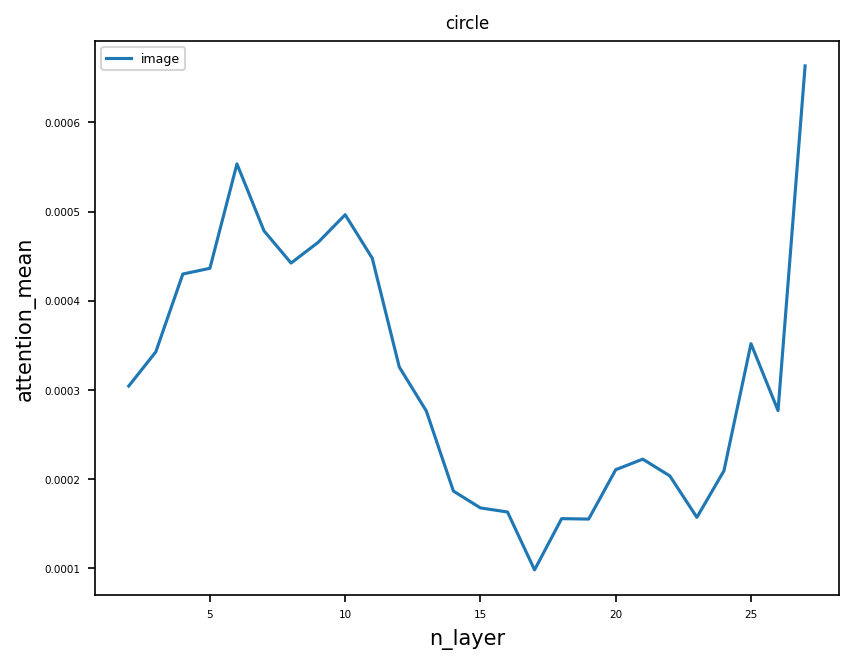

In [48]:
plot_data(data, ["circle"], data_id=1, xlabel='n_layer', ylabel='prob', start_layer=set_layer)
plot_data(data, ["circle"], data_id=2, dy=0.3, xlabel='n_layer', ylabel='entropy', start_layer=set_layer)
plot_data(data, ["circle"], data_id=3, xlabel='n_layer', ylabel='cos_dist', start_layer=set_layer)
plot_data_attention(data_attention, ["circle"], label="image", xlabel='n_layer', ylabel='attention_mean', start_layer=set_layer)

In [49]:
super_pixels

[308,
 308,
 313,
 313,
 313,
 313,
 313,
 313,
 313,
 313,
 313,
 313,
 272,
 313,
 313,
 272,
 313,
 245,
 319,
 294,
 245,
 294,
 294,
 313,
 245,
 313,
 437,
 437,
 510,
 313]

Генерация:

In [50]:
print(model.generate("USER: <image>\nWhat is the shape of the object in the image? ASSISTANT: The shape of the object is a", input_images=images[3], max_new_tokens=30, do_sample=False))

  7%|▋         | 2/30 [00:06<01:35,  3.42s/it]


USER: <image> 
What is the shape of the object in the image? ASSISTANT: The shape of the object is a triangle.</s>
